# U-Net Fine-Tuning for Image Classification on Modified Mini-GCD Dataset with Classification Head

### 0. Setup Environment

#### 0.1. Library Imports

In [23]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import segmentation_models_pytorch as smp
from torch.optim.lr_scheduler import ReduceLROnPlateau, CyclicLR
import random
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch.nn.functional as F
from torchvision.utils import make_grid


#### 0.2. Checking GPU availability

In [24]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

True
1
0
NVIDIA GeForce RTX 3050 Ti Laptop GPU
cuda


#### 0.3 Setting hyperparams

In [25]:
# Dataset directories
data_dirs = [ "mini-GCD-modified", "GCD-modified"] # Dataset directories
selected_data_dir = data_dirs[0] # Selected dataset directory

# Model directory and filename
model_folder = "model_src" # Model folder
model_filename = os.path.join(model_folder, "unet_model.pth") # Model filename

# Training hyperparameters
num_epochs = 20 # Number of epochs to train
patience = 10 # Number of epochs with no improvement before early stopping

# Results directory
scenario = "v2" # Scenario name
results_dir = "results/unet/" + selected_data_dir + "/" + scenario + "/" # Results directory

#### 0.4 Create Directories and Utility Functions

In [26]:
# Create directories
os.makedirs(model_folder, exist_ok=True)

# Create results directory
def try_create_results_dir(results_dir):
    os.makedirs(results_dir, exist_ok=True)
    print(f"Results Directory: {results_dir}")

#### 1. Define Dataset and Transformations

In [27]:
# Define train dataloader with online data augmentation
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Define validation and test dataloaders
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Specify the dataset directories
train_dir = os.path.join(selected_data_dir, "train")
val_dir = os.path.join(selected_data_dir, "val")
test_dir = os.path.join(selected_data_dir, "test")

train_dataset = ImageFolder(root=train_dir, transform=transform_train)
val_dataset = ImageFolder(root=val_dir, transform=transform_val)
test_dataset = ImageFolder(root=test_dir, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

# Class Names
class_names = train_dataset.classes
print(f"Classes: {class_names}")

# Show number of training samples per class
train_class_counts = {class_names[i]: 0 for i in range(len(class_names))}
for _, label in train_dataset:
    train_class_counts[class_names[label]] += 1
print("Train Class Counts:", train_class_counts)

# Display the number of training samples
print(f"Total number of training samples: {len(train_dataset)}")

Classes: ['1_cumulus', '2_altocumulus', '3_cirrus', '4_clearsky', '5_stratocumulus', '6_cumulonimbus', '7_mixed']
Train Class Counts: {'1_cumulus': 49, '2_altocumulus': 49, '3_cirrus': 49, '4_clearsky': 49, '5_stratocumulus': 49, '6_cumulonimbus': 49, '7_mixed': 49}
Total number of training samples: 343


### 2. Load model

#### 2.1. Load the U-Net Model (Pre-trained)

In [28]:
# Load the pre-trained U-Net model
# unet = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", classes=len(class_names), activation=None)
unet = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", classes=2, activation=None)

#### 2.2. Setup U-Net-based Image Classifier

In [29]:
# Define the UNetClassifier
class UNetClassifier(nn.Module):
    def __init__(self, unet, num_classes):
        super(UNetClassifier, self).__init__()
        self.unet = unet
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.BatchNorm1d(unet.segmentation_head[0].out_channels),
            nn.Dropout(0.5),
            nn.Linear(unet.segmentation_head[0].out_channels, unet.segmentation_head[0].out_channels),
            nn.ReLU(),
            nn.Linear(unet.segmentation_head[0].out_channels, num_classes)
        )

    def forward(self, x):
        features = self.unet(x)
        out = self.classifier(features)
        return out

def initialize_weights(layer):
    if isinstance(layer, nn.Linear):
        nn.init.xavier_uniform_(layer.weight)
        if layer.bias is not None:
            nn.init.zeros_(layer.bias)

def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Instantiate classifier and to device (GPU or CPU)
num_classes = len(train_dataset.classes)
classifier = UNetClassifier(unet, num_classes).to(device)
classifier.classifier.apply(initialize_weights)
print(f"Trainable Parameters: {count_trainable_params(classifier):,}")

# Define Optimizer
# optimizer = optim.Adam(classifier.parameters(), lr=0.001, weight_decay=1e-5)
optimizer = optim.AdamW(classifier.parameters(), lr=0.001, weight_decay=1e-4)

# Define Learning rate scheduler
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
scheduler = CyclicLR(optimizer, base_lr=1e-5, max_lr=1e-3, step_size_up=2000, mode='triangular')

# Define Loss function
# criterion = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

Trainable Parameters: 24,436,545


### 3. Training

C:\global_envs\pytorch_env\Lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/20, Train Loss: 2.0884, Val Loss: 2.0637 [*]
Epoch 2/20, Train Loss: 2.0259, Val Loss: 2.0798
Epoch 3/20, Train Loss: 2.0267, Val Loss: 2.0260 [*]
Epoch 4/20, Train Loss: 1.9610, Val Loss: 2.0431
Epoch 5/20, Train Loss: 1.9390, Val Loss: 2.1245
Epoch 6/20, Train Loss: 1.9420, Val Loss: 2.0644
Epoch 7/20, Train Loss: 1.9317, Val Loss: 1.9680 [*]
Epoch 8/20, Train Loss: 1.8741, Val Loss: 2.0637
Epoch 9/20, Train Loss: 1.8971, Val Loss: 2.0798
Epoch 10/20, Train Loss: 1.9219, Val Loss: 1.9549 [*]
Epoch 11/20, Train Loss: 1.8729, Val Loss: 2.0197
Epoch 12/20, Train Loss: 1.8702, Val Loss: 2.0269
Epoch 13/20, Train Loss: 1.8738, Val Loss: 1.9685
Epoch 14/20, Train Loss: 1.8582, Val Loss: 2.0736
Epoch 15/20, Train Loss: 1.8717, Val Loss: 1.9099 [*]
Epoch 16/20, Train Loss: 1.8551, Val Loss: 1.9338
Epoch 17/20, Train Loss: 1.8378, Val Loss: 1.9911
Epoch 18/20, Train Loss: 1.8380, Val Loss: 2.0251
Epoch 19/20, Train Loss: 1.8433, Val Loss: 1.8841 [*]
Epoch 20/20, Train Loss: 1.8330, Va

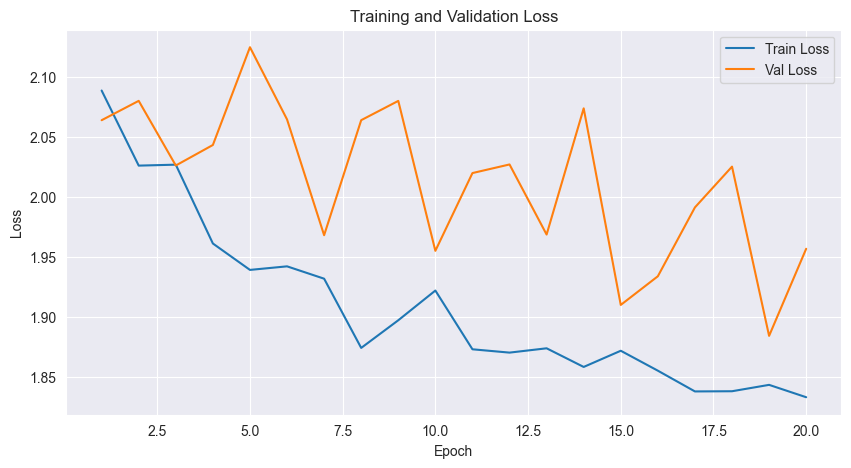

In [30]:
# Train the model
def train_model(classifier, train_loader, val_loader, epochs=30):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    current_epochs = 0

    for epoch in range(epochs):
        current_epochs = epoch + 1

        classifier.train()

        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = classifier(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(classifier.parameters(), max_norm=1.0)
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation loop
        classifier.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = classifier(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)

        val_loss = val_running_loss / len(val_loader.dataset)
        val_losses.append(val_loss)

        # Update learning rate
        scheduler.step(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save the best model
            torch.save(classifier.state_dict(), model_filename)
            saved = True
        else:
            patience_counter += 1
            saved = False
            if patience_counter >= patience:
                print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f} -> Early Stopping")
                break

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}" + (" [*]" if saved else ""))


    return train_losses, val_losses, current_epochs

def plot_losses(train_losses, val_losses, num_epochs=num_epochs):
    # Plot training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# Train the model and plot losses
train_losses, val_losses, current_epochs = train_model(classifier, train_loader, val_loader, epochs=num_epochs)
plot_losses(train_losses, val_losses, num_epochs=current_epochs)

#### 3.2. (Re)load the Model

In [31]:
# Save the trained model
# save_model(model, 'unet_classifier.pth')

# Load the model back
classifier.load_state_dict(torch.load(model_filename))
classifier.to(device)

classifier.eval()

C:\Users\Stefan\AppData\Local\Temp\ipykernel_32948\783107864.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classifier.load_state_dict(torch.load(model_filename))


UNetClassifier(
  (unet): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): B

### 5. Evaluate the model

In [32]:
# Evaluate Model
def predict_model(classifier, dataloader: DataLoader, class_names):
    """
    Utility function to predict model on a dataset
    :param classifier:
    :param dataloader:
    :param class_names:
    :return:
    """
    classifier.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = classifier(inputs)

            # Get probabilities and predictions
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Convert lists to numpy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

def generate_confusion_matrix(labels, preds, class_names, save_results=False):
    """
    Utility function to generate confusion matrix
    :param labels:
    :param preds:
    :param class_names:
    :return:
    """
    # Create Confusion Matrix
    cm = confusion_matrix(labels, preds, labels=range(len(class_names)))

    # Plot Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.axis("off")

    if save_results:
        try_create_results_dir(results_dir)
        plt.savefig(results_dir + "confusion_matrix.png")

    plt.show()

def generate_classification_report(labels, preds, class_names, save_results=False):
    """
    Utility function to generate classification report
    :param labels:
    :param preds:
    :param class_names:
    :return:
    """
    # Generate Classification Report
    report = classification_report(labels, preds, target_names=class_names)
    print(report)

    if save_results:
        try_create_results_dir(results_dir)
        with open(results_dir + "classification_report.txt", "w") as f:
            f.write(report)

def evaluate_model(classifier, dataloader, class_names, save_results=False):
    """
    Utility wrapper function to evaluate model on a dataset
    :param classifier:
    :param dataloader:
    :param class_names:
    :return:
    """
    preds, labels, probs = predict_model(classifier, dataloader, class_names)
    generate_confusion_matrix(labels, preds, class_names, save_results)
    generate_classification_report(labels, preds, class_names, save_results)
    return preds, labels, probs

#### 5.2. Utility Function for Plotting Random Samples

In [33]:
# Plot Random Samples
def plot_random_samples(dataset, preds, labels, probs, class_names, num_cols=4, num_samples=5, save_results=False):
    num_samples = min(num_samples, len(dataset))

    # Randomly select indices
    random_indices = random.sample(range(len(dataset)), num_samples)

    # Calculate number of rows needed
    num_rows = (num_samples + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))
    axes = axes.flatten()

    for i, idx in enumerate(random_indices):
        image, true_label = dataset[idx]
        image = (image * 0.5 + 0.5)  # Unnormalize
        image = np.clip(image, 0, 1)
        pred_label = preds[idx]
        prob = probs[idx, pred_label]  # Probability of predicted class

        axes[i].imshow(image.permute(1, 2, 0))  # Convert CHW to HWC for plotting
        axes[i].axis("off")
        axes[i].set_title(
            f"True: {class_names[true_label]}\n"
            f"Pred: {class_names[pred_label]} ({prob:.2f})"
        )

    # Hide any remaining empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()

    if save_results:
        try_create_results_dir(results_dir)
        plt.savefig(results_dir + "random_samples.png")

    plt.show()

#### 5.3. Evaluate model on train and test datasets

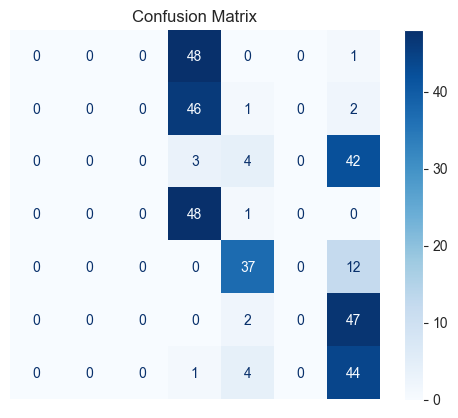

C:\global_envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\global_envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\global_envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                 precision    recall  f1-score   support

      1_cumulus       0.00      0.00      0.00        49
  2_altocumulus       0.00      0.00      0.00        49
       3_cirrus       0.00      0.00      0.00        49
     4_clearsky       0.33      0.98      0.49        49
5_stratocumulus       0.76      0.76      0.76        49
 6_cumulonimbus       0.00      0.00      0.00        49
        7_mixed       0.30      0.90      0.45        49

       accuracy                           0.38       343
      macro avg       0.20      0.38      0.24       343
   weighted avg       0.20      0.38      0.24       343

Results Directory: results/unet/mini-GCD-modified/v2/


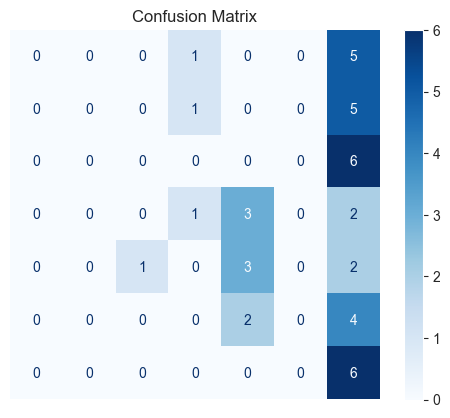

C:\global_envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\global_envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\global_envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                 precision    recall  f1-score   support

      1_cumulus       0.00      0.00      0.00         6
  2_altocumulus       0.00      0.00      0.00         6
       3_cirrus       0.00      0.00      0.00         6
     4_clearsky       0.33      0.17      0.22         6
5_stratocumulus       0.38      0.50      0.43         6
 6_cumulonimbus       0.00      0.00      0.00         6
        7_mixed       0.20      1.00      0.33         6

       accuracy                           0.24        42
      macro avg       0.13      0.24      0.14        42
   weighted avg       0.13      0.24      0.14        42

Results Directory: results/unet/mini-GCD-modified/v2/
Results Directory: results/unet/mini-GCD-modified/v2/


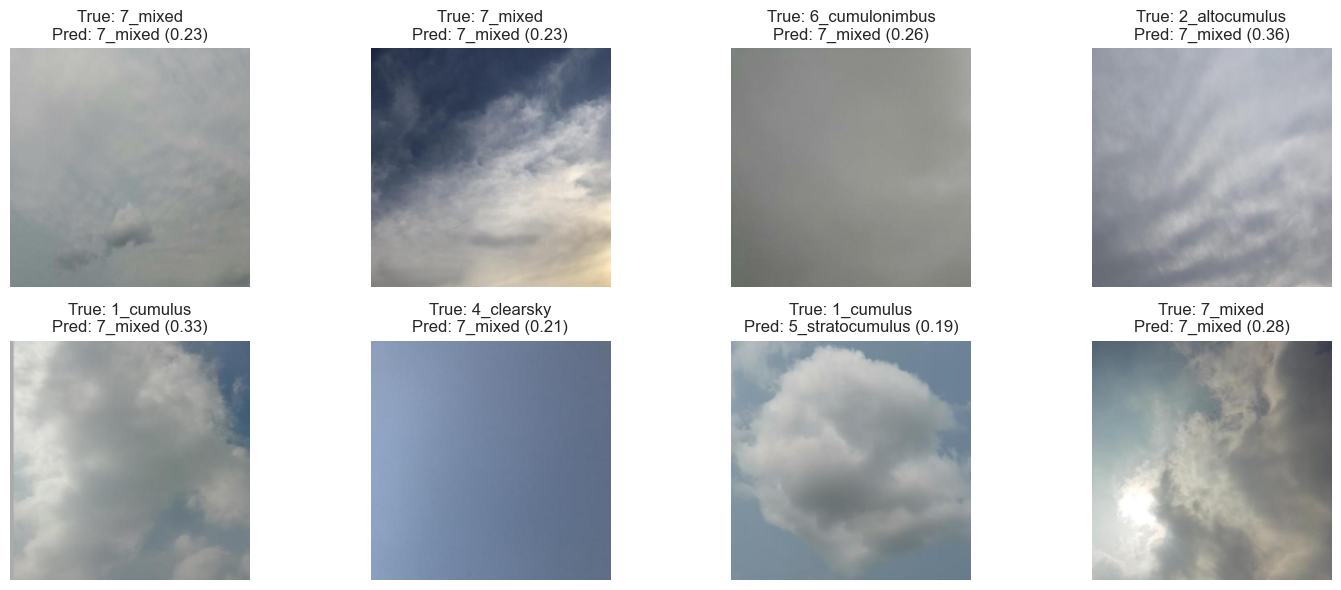

In [34]:
# Evaluate Model on train dataset
evaluate_model(classifier, train_loader, class_names)

# Evaluate Model on test dataset
preds, labels, probs = evaluate_model(classifier, test_loader, class_names, save_results=True)

# Plot random samples
plot_random_samples(test_dataset, preds, labels, probs, class_names, num_cols=4, num_samples=8, save_results=True)

### 6. Visualize the Model Predictions

torch.Size([8, 3, 224, 224]) torch.Size([8])


C:\Users\Stefan\AppData\Local\Temp\ipykernel_32948\3894265689.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


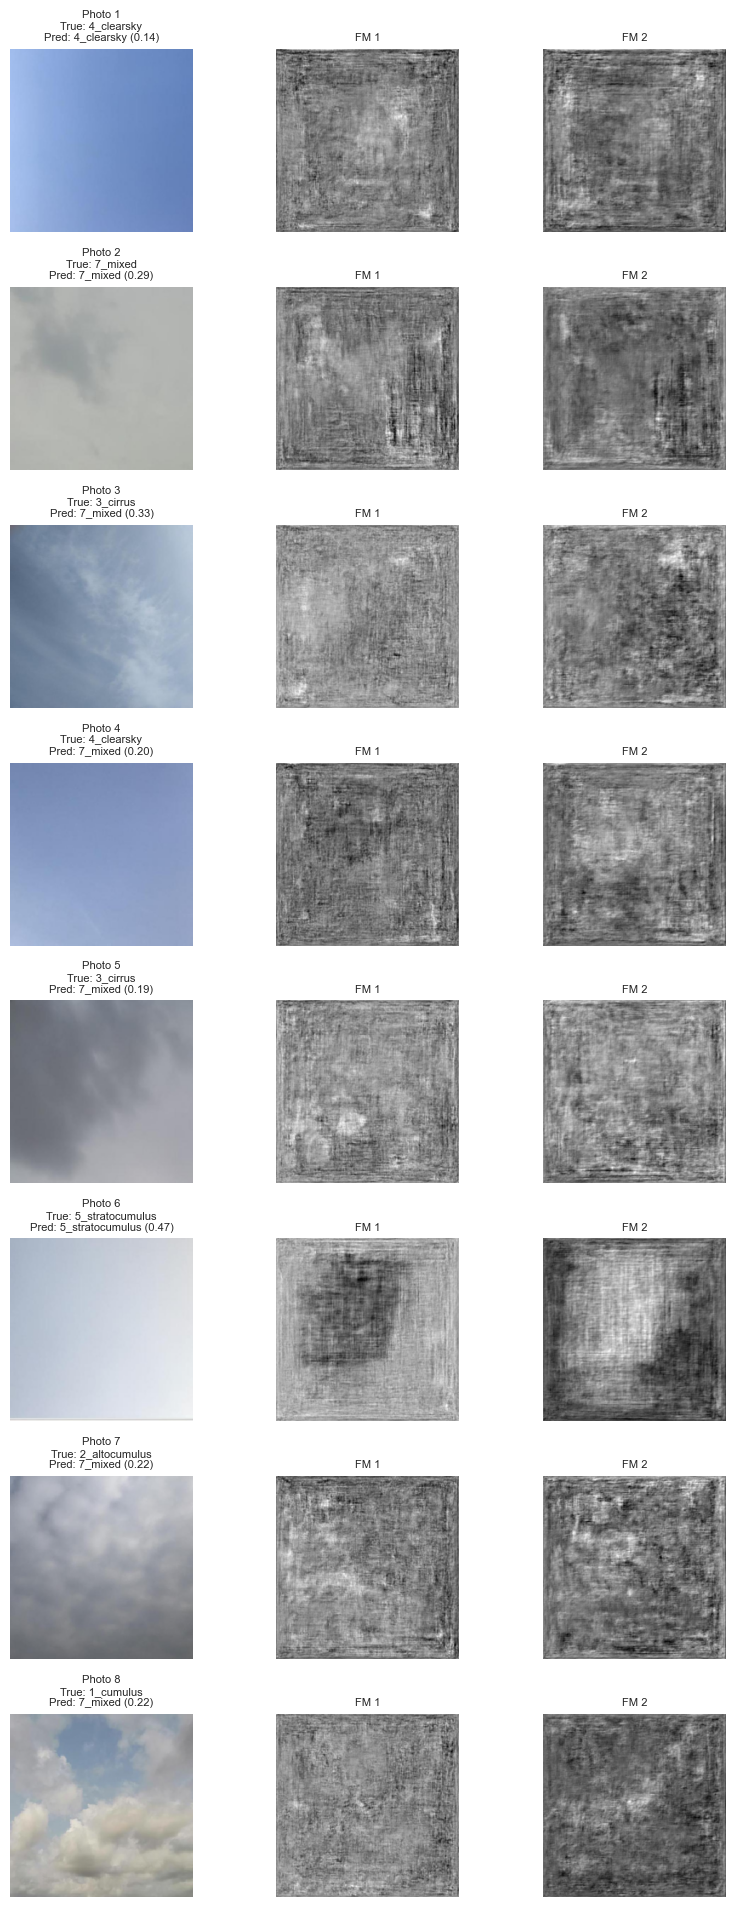

Ground Truth Labels: [3 6 2 3 2 4 1 0]
Predicted Labels: [3 6 6 6 6 4 6 6]
Accuracy: 0.3750
Precision: 0.3958
Recall: 0.3750
F1 Score: 0.3274


C:\global_envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ValueError: Number of classes, 6, does not match size of target_names, 7. Try specifying the labels parameter

In [35]:
num_batches = 1
batch_size = 8

# Pass the images through the model and visualize the intermediate feature maps
def forward_pass_with_feature_maps(model, images, device):
    images = images.to(device)
    model.eval()
    with torch.no_grad():
        features = model.unet(images)
        outputs = model.classifier(features)
    return features, outputs

# Function to visualize feature maps
def visualize_all_feature_maps(
    features, sample_images, sample_labels, predicted_labels, probabilities, class_names, num_classes, image_resize=(128, 128)
):
    """
    Visualize all feature maps for the batch in a single plot with smaller images and readable class labels.

    Args:
        features (torch.Tensor): Feature maps (batch_size, num_classes, height, width).
        sample_images (torch.Tensor): Original images (batch_size, channels, height, width).
        sample_labels (torch.Tensor): Ground truth labels (batch_size).
        predicted_labels (list): Predicted labels (batch_size).
        probabilities (list): Predicted probabilities (batch_size).
        class_names (list): List of class names.
        num_classes (int): Number of feature maps per image.
        image_resize (tuple): Size to resize the images (height, width).
    """
    batch_size = features.shape[0]

    # Reduce figure size for compact layout
    fig, axes = plt.subplots(
        batch_size,
        num_classes + 1,
        figsize=(10, 3 * batch_size),  # Adjust figure size
        gridspec_kw={"wspace": 0.1, "hspace": 0.3},  # Add tighter spacing
    )

    if batch_size == 1:
        axes = [axes]  # Handle single-row case

    for i in range(batch_size):
        # Resize and unnormalize the original image
        original_img = sample_images[i].cpu()
        original_img = F.interpolate(original_img.unsqueeze(0), size=image_resize).squeeze(0)
        original_img = (original_img * 0.5 + 0.5).permute(1, 2, 0).numpy()

        # Plot the original image
        axes[i][0].imshow(original_img)
        axes[i][0].axis("off")
        axes[i][0].set_title(
            f"Photo {i + 1}\nTrue: {class_names[sample_labels[i].item()]}\n"
            f"Pred: {class_names[predicted_labels[i]]} ({probabilities[i]:.2f})",
            fontsize=8,
        )

        # Plot feature maps
        for j in range(num_classes):
            feature_map = features[i, j].cpu().numpy()
            axes[i][j + 1].imshow(feature_map, cmap="gray")
            axes[i][j + 1].axis("off")
            axes[i][j + 1].set_title(f"FM {j + 1}", fontsize=8)

    plt.tight_layout()
    plt.show()

# Select a few sample images from the test dataset
def get_sample_images(test_loader, num_batches=2):
    sample_images = []
    sample_labels = []
    for images, labels in test_loader:
        sample_images.append(images)
        sample_labels.append(labels)
        if len(sample_images) >= num_batches:
            break
    return torch.cat(sample_images), torch.cat(sample_labels)

# Get sample images and labels
sample_images, sample_labels = get_sample_images(test_loader, num_batches=num_batches)
resized_sample_images = F.interpolate(sample_images, size=(256, 256))
print(sample_images.shape, sample_labels.shape)

# Get feature maps and outputs
features, outputs = forward_pass_with_feature_maps(classifier, sample_images, device)

# Predicted labels and probabilities
_, predicted = torch.max(outputs, 1)
predicted = predicted.cpu().numpy()
probabilities = [torch.softmax(outputs[i], dim=0)[predicted[i]].item() for i in range(len(predicted))]

# Resize feature maps to match the size of the original images
features_resized = F.interpolate(features, size=(256, 256), mode='bilinear', align_corners=False)

# Visualize feature maps per photo
visualize_all_feature_maps(
    features=features_resized,  # Resized feature maps
    sample_images=resized_sample_images,  # Resized original images
    sample_labels=sample_labels,  # True labels
    predicted_labels=predicted,  # Predicted labels
    probabilities=probabilities,  # Predicted probabilities
    class_names=class_names,  # Class names
    num_classes=features_resized.shape[1],  # Number of feature maps
    image_resize=(256, 256),  # Resize images for visualization
)

# Print the ground truth and predicted labels
print("Ground Truth Labels:", sample_labels.cpu().numpy())
print("Predicted Labels:", predicted)

# Print evaluation metrics for the sampled images
accuracy = accuracy_score(sample_labels.cpu().numpy(), predicted)
precision = precision_score(sample_labels.cpu().numpy(), predicted, average="weighted")
recall = recall_score(sample_labels.cpu().numpy(), predicted, average="weighted")
f1 = f1_score(sample_labels.cpu().numpy(), predicted, average="weighted")

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Print classification report
print(classification_report(sample_labels.cpu().numpy(), predicted, target_names=train_dataset.classes))

# Plot confusion matrix
cm = confusion_matrix(sample_labels.cpu().numpy(), predicted)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes,
            cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()